# Predicción del valor de Bitcoin

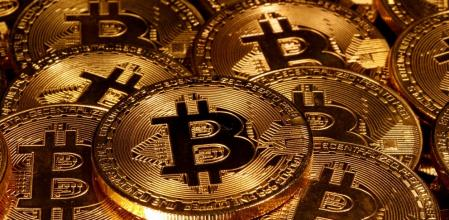

A partir del dataset `data/Binance_BTCUSDT_d.csv` implementa un modelo de series temporales para predecir el precio diario de cierre del Bitcoin en dólares

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data/Binance_BTCUSDT_d.csv',header=1,parse_dates=['date'])
data = data.sort_values('date')
print(data.shape)
data.head()

(1434, 10)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
1433,1.502928e+09,2017-08-17,BTC/USDT,4469.93,4485.39,4200.74,4285.08,647.86,2812379.11,NaN
1432,1.503014e+09,2017-08-18,BTC/USDT,4285.08,4371.52,3938.77,4108.37,1178.07,4994493.56,NaN
1431,1.503101e+09,2017-08-19,BTC/USDT,4108.37,4184.69,3850.00,4139.98,371.15,1508239.39,NaN
1430,1.503187e+09,2017-08-20,BTC/USDT,4139.98,4211.08,4032.62,4086.29,463.54,1915636.35,NaN
1429,1.503274e+09,2017-08-21,BTC/USDT,4086.29,4119.62,3911.79,4016.00,685.12,2770592.06,NaN


<AxesSubplot:xlabel='date'>

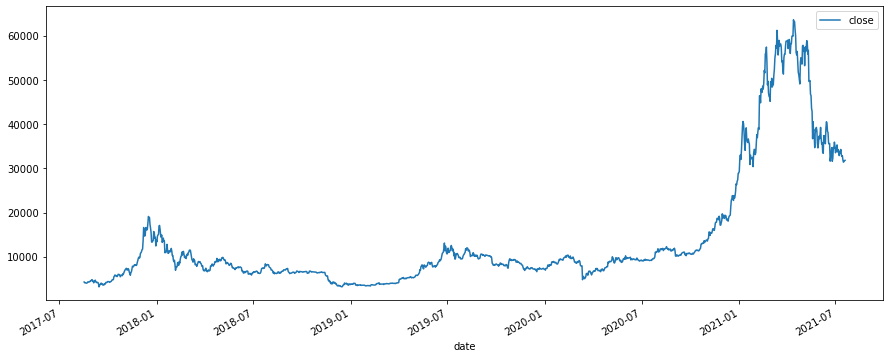

In [3]:
data[['date','close']].plot(x='date',y='close',figsize=(15,6))

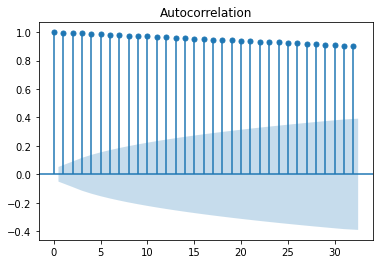

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['close']);

In [5]:
X = data['close'].values
tp = int(1434*0.90)

train = X[:tp]
test = X[tp:]

In [6]:
len(train),len(test)

(1290, 144)

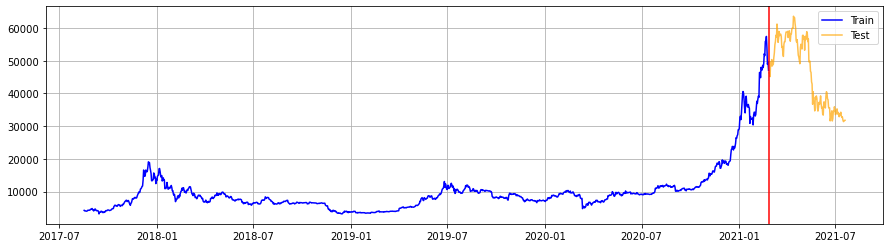

In [7]:
import matplotlib.pyplot as plt

index = data.date.values
plt.figure(figsize=(15,4))
plt.plot(index[0:tp],train,c='blue')
plt.plot(index[tp:],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(index[tp], c="r")
plt.grid()

# 1. ARIMA

In [79]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

p = range(2,5)
d = range(2,3)
q = range(2,5)

pdq = list(itertools.product(p,d,q))


In [80]:
results = []

for param in pdq:
    model_arima = ARIMA(train, order=param)
    model_arima_fit = model_arima.fit()
    results.append((param, model_arima_fit.aic))

C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizati

In [81]:
resultados_df = pd.DataFrame(results, columns=['ARIMA params','AIC']).sort_values('AIC')
resultados_df

,ARIMA params,AIC
2,"(2, 2, 4)",20151.347912
5,"(3, 2, 4)",20154.295068
4,"(3, 2, 3)",20154.632215
8,"(4, 2, 4)",20155.366744
7,"(4, 2, 3)",20155.514329
1,"(2, 2, 3)",20159.509283
6,"(4, 2, 2)",20170.676901
3,"(3, 2, 2)",20174.436658
0,"(2, 2, 2)",20179.914073


In [189]:
best_model = ARIMA(train, order=(2,2,4))
best_model_fit = best_model.fit()
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1290
Model:                 ARIMA(2, 2, 4)   Log Likelihood              -10068.674
Date:                Tue, 27 Jul 2021   AIC                          20151.348
Time:                        18:54:22   BIC                          20187.474
Sample:                             0   HQIC                         20164.909
                               - 1290                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2279      0.019    -65.435      0.000      -1.265      -1.191
ar.L2         -0.9803      0.017    -57.695      0.000      -1.014      -0.947
ma.L1          0.2709      0.023     11.870      0.0

In [190]:
from sklearn.metrics import mean_squared_error
predictions = best_model_fit.predict(start=1290, end=1290+143)
print(mean_squared_error(test,predictions))

513893670.9894792


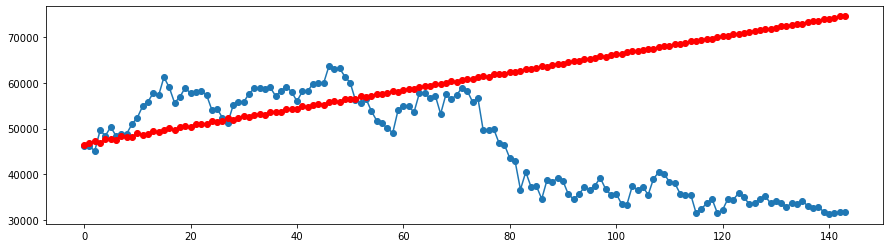

In [193]:
plt.figure(figsize=(15,4))
plt.plot(test,'o-')
plt.plot(predictions, 'o-', color='red')

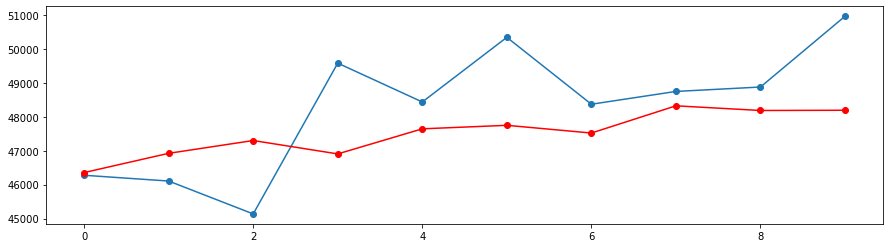

In [195]:
plt.figure(figsize=(15,4))
plt.plot(test[0:10],'o-')
plt.plot(predictions[0:10], 'o-', color='red')


# 2. LSTM

In [8]:
N = data.shape[0]
df2 = data[['close']].copy()
emb_size = 4
for i in range(1, emb_size+1):
    df2['lag' + str(i)] = df2['close'].shift(i)

df2.dropna(inplace=True)
df2.reset_index(drop=True, inplace=True)

values = df2.values
trainX, trainY = values[0:tp-emb_size,1:], values[0:tp-emb_size,0]
testX, testY = values[tp-emb_size:N-emb_size,1:], values[tp-emb_size:N-emb_size,0]

print("Train data length:", trainX.shape)
print("Train target length:", trainY.shape)
print("Test data length:", testX.shape)
print("Test target length:", testY.shape)

Train data length: (1286, 4)
Train target length: (1286,)
Test data length: (144, 4)
Test target length: (144,)


In [9]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(trainX)
# trainX2 = scaler.transform(trainX)
# testX2 = scaler.transform(testX)

In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# trainX = np.reshape(trainX2, (trainX2.shape[0], 1, trainX2.shape[1]))
# testX = np.reshape(testX2, (testX2.shape[0], 1, testX2.shape[1]))

In [11]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (1286, 1, 4) ,  (1286,)
Test data shape: (144, 1, 4) ,  (144,)


In [12]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

def build_simple_rnn(num_units=128, embedding=4, num_dense=32, lr=0.001):
    """
    Builds and compiles a RNN model
    Arguments:
             num_units: Number of units of a RNN layer
             embedding: Embedding length
             num_dense: Number de neuronas in the dense layer
             lr: Learning rate
     Returns:
             A compiled Keras model
    """
    model = Sequential()
    model.add(LSTM(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=lr),
                 metrics=['mse'])
    
    return model

In [13]:
model = build_simple_rnn()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 72,257
Trainable params: 72,257
Non-trainable params: 0
_________________________________________________________________


In [15]:
'''
Enseña mensaje si la epoch es multiplo de 50 y no ha acabado de entrenar.
Cada vez que termina una epoch, keras llama a on_epoch_end()
'''
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [16]:
batch_size=16
num_epochs = 50

In [17]:
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done


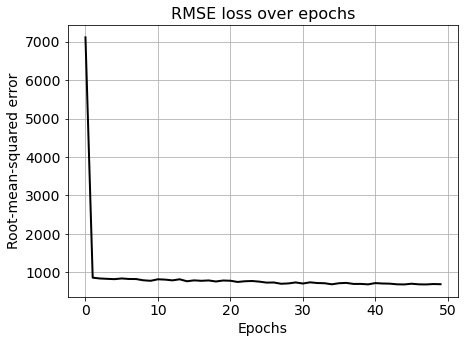

In [18]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [19]:
testPredict = model.predict(testX)

In [67]:
print(mean_squared_error(test,testPredict))

NameError: name 'mean_squared_error' is not defined

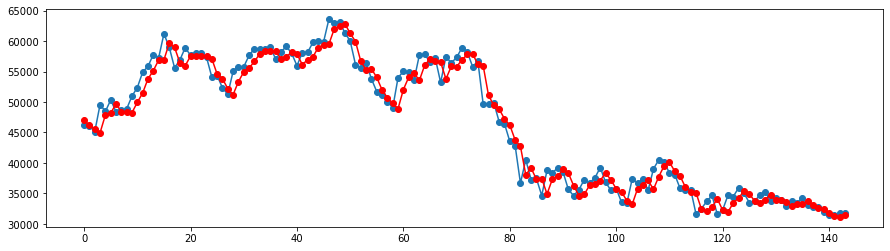

In [20]:
plt.figure(figsize=(15,4))
plt.plot(test,'o-')
plt.plot(testPredict, 'o-', color='red')

In [22]:
np.corrcoef(test,testPredict.reshape(-1))

array([[1.        , 0.98214702],
       [0.98214702, 1.        ]])

In [23]:
def prediction(model, x_test):
    preds = x_test[0]
    preds_out = []
    
    for i in range(len(x_test)):
        if i ==0:
            pred = model.predict(np.expand_dims(preds, axis=0)).reshape(-1)
        else: 
            pred = model.predict(np.expand_dims([preds], axis=0)).reshape(-1)
        preds_out.append(pred)

        preds2 = np.array([preds.reshape(-1)[1:]])
        
        '''
        Concatenamos la nueva, es decir, el nuevo t-1
        '''
        preds = np.c_[preds2, np.array([pred])][0]
    return preds_out


In [24]:
testPredict = prediction(model,testX)

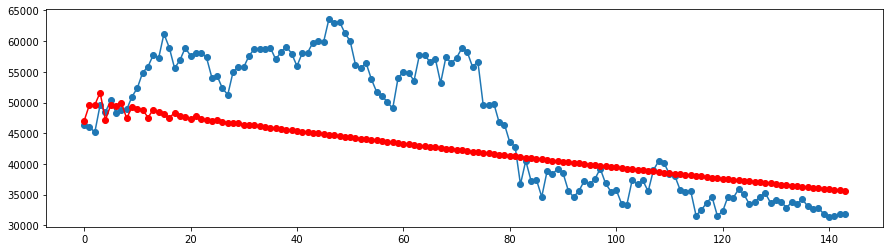

In [25]:
plt.figure(figsize=(15,4))
plt.plot(test,'o-')
plt.plot(testPredict, 'o-', color='red')

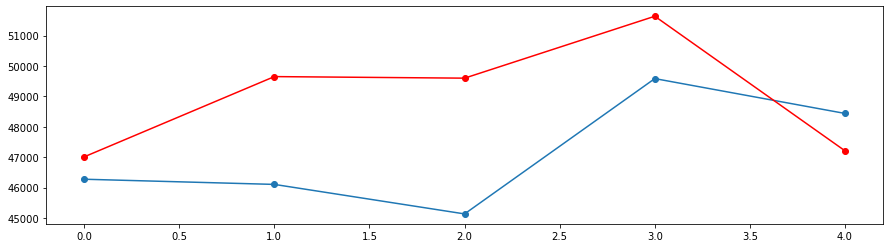

In [26]:
plt.figure(figsize=(15,4))
plt.plot(test[0:5],'o-')
plt.plot(testPredict[0:5], 'o-', color='red')

In [27]:
def prediction2(model, x_test):
    preds = x_test[0]
    preds_out = []
    
    for i in range(len(x_test)):
        if i ==0:
            pred = model.predict(np.expand_dims(preds, axis=0)).reshape(-1)
        else: 
            pred = model.predict(np.expand_dims([preds], axis=0)).reshape(-1)
        preds_out.append(pred)

        preds2 = np.array([preds.reshape(-1)[0:-1]])
        
        '''
        Concatenamos la nueva, es decir, el nuevo t-1
        '''
        preds = np.c_[preds2, np.array([pred])][0]
    return preds_out


In [28]:
testPredict2 = prediction2(model,testX)

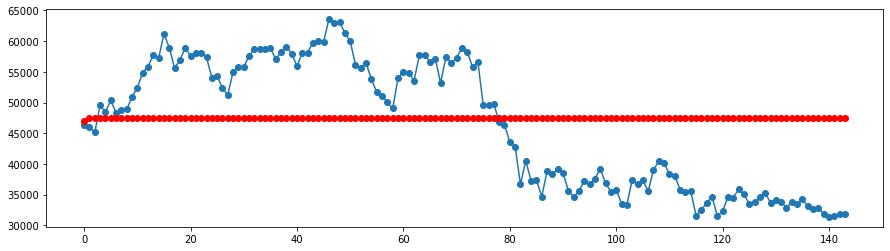

In [29]:
plt.figure(figsize=(15,4))
plt.plot(test,'o-')
plt.plot(testPredict2, 'o-', color='red')

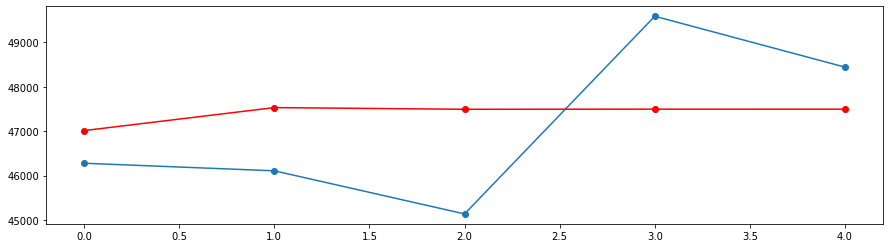

In [31]:
plt.figure(figsize=(15,4))
plt.plot(test[0:5],'o-')
plt.plot(testPredict2[0:5], 'o-', color='red')